In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

## The Simple Compartmental Model SEIRD
S - Susceptible
E - Exposed
I - Infectious
R - Recovered
D - Dead

In [2]:

# the SEIR model differential equations
def deriv(t, y, N, beta, sigma, gamma, delta):
    S, E, I, R, D = y
    dSdt = -beta * S * I / (N-D)
    dEdt = beta * S * I / (N-D) - sigma * E
    dIdt = sigma * E - (gamma + delta) * I
    dRdt = gamma * I
    dDdt = delta * I
    return dSdt, dEdt, dIdt, dRdt, dDdt

In [3]:
# theotal population we are modeling -  N
N = 1000
# the initial number of infected and recovered individuals in our data
I0, R0 = 1, 0
# the initial number of exposed individuals in our data
E0 = 0
# the initial number of folk dead from the disease is zero
D0 = 0
# everyone else, S0, is susceptible to infection initially
S0 = N - I0 - R0 - E0 - D0
# the contact rate, beta, incubation rate, sigma, and mean recovery rate, gamma
beta, sigma, gamma, delta = 0.3, 1/5.2, 1/10, 1/150
# the time points (days) over which we want to predict using our model
t = np.linspace(0, 160, 640)

# here we set the initial conditions vector
y0 = S0, E0, I0, R0, D0

In [4]:

# Now we use scipy to solve the system of differential equations
sol = solve_ivp(deriv, [0, 160], y0, args=(N, beta, sigma, gamma, delta), t_eval=t)

# extract the results
S, E, I, R, D = sol.y

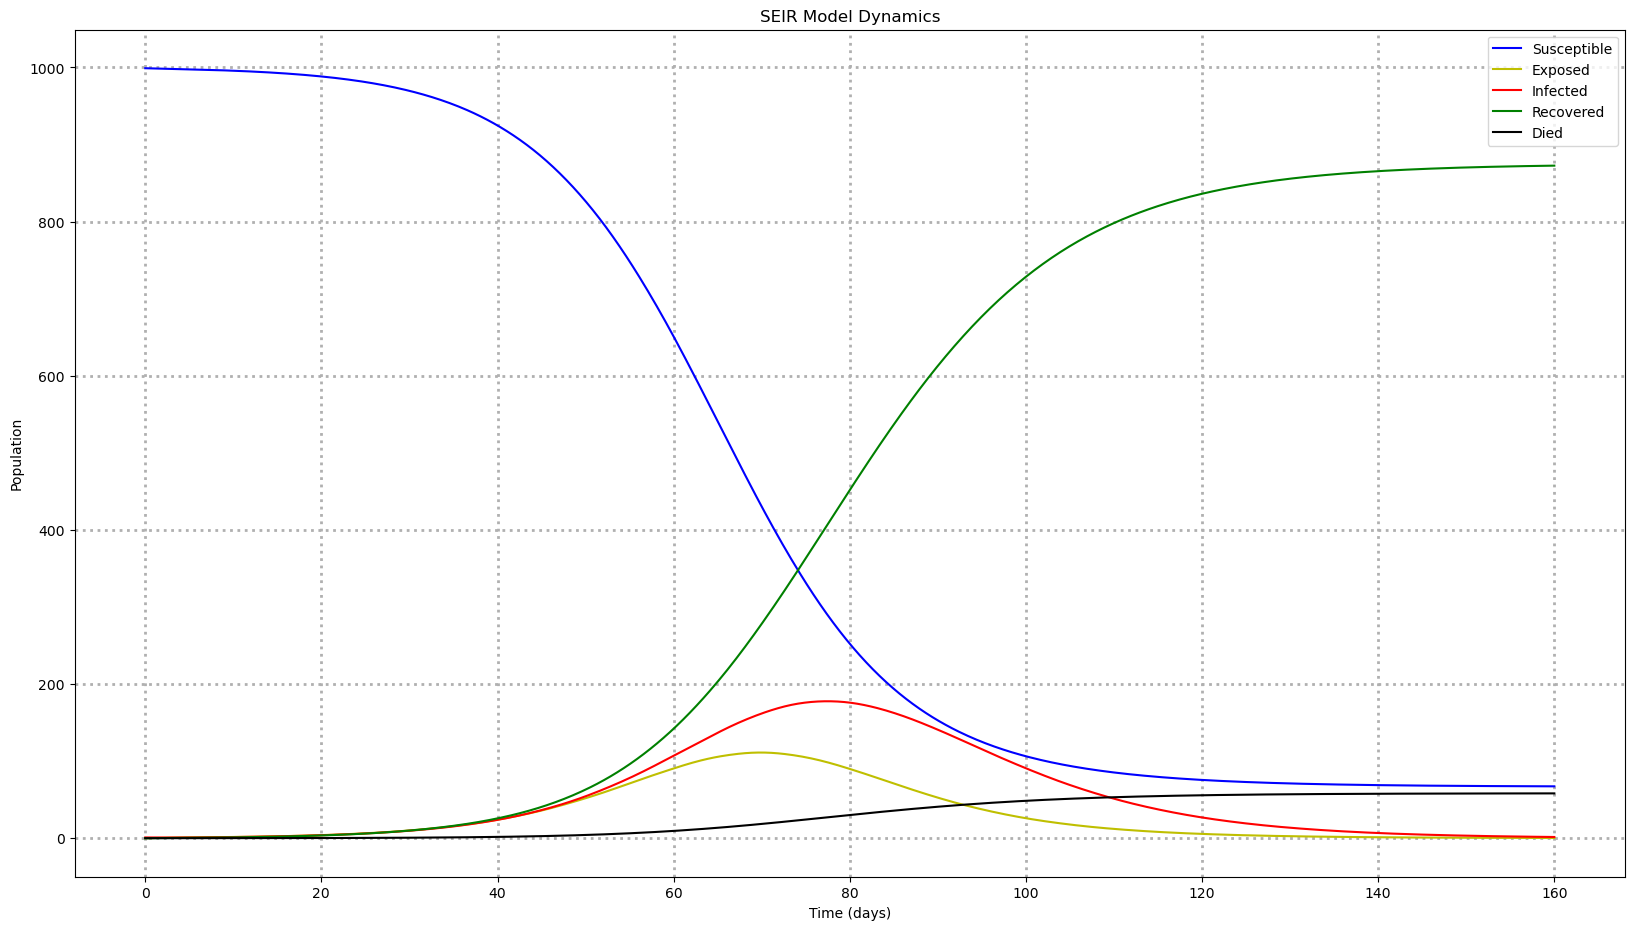

In [5]:

# plot the data on four separate curves for S(t), E(t), I(t) and R(t)
plt.figure(figsize=(20,11))
plt.plot(t, S, 'b', label='Susceptible')
plt.plot(t, E, 'y', label='Exposed')
plt.plot(t, I, 'r', label='Infected')
plt.plot(t, R, 'g', label='Recovered')
plt.plot(t, D, 'k', label='Died')
plt.title("SEIR Model Dynamics")
plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.legend()
plt.grid(lw=2,ls=":")
plt.show()

## Adding age compartments

To start simple, doing just two coupled groups. Given we want to look at ages, we call them "young" and "old", for now. 

And, for now, we shall have a constant coupling parameter $\theta$ between their infected boxes. $\theta$ represents the relative likelihood of meeting someone from the opposite group. It is like a perturbation to beta. We assume $|\theta| ~ 1$. Small theta implies that the groups are less likely to mix. $\theta << 1$ gives 

In [6]:
# the SEIR model differential equations
def deriv(t, Y, N_y, N_o, beta_ybox, beta_obox, sigma, gamma, delta, theta_yo, theta_oy):
    Y_y , Y_o = Y.reshape(2,5)
    S_y, E_y, I_y, R_y, D_y = Y_y
    S_o, E_o, I_o, R_o, D_o = Y_o

    Y_ybox = (1.0 - theta_yo)*Y_y + theta_oy*Y_o
    Y_obox = (1.0 - theta_oy)*Y_o + theta_yo*Y_y

    N_ybox = (1.0 - theta_yo)*(N_y-D_y) - theta_oy * (N_o - D_o)
    N_obox = (1.0 - theta_oy)*(N_o-D_o) - theta_yo * (N_y - D_y)
    
    S_ybox, E_ybox, I_ybox, R_ybox, D_ybox = Y_ybox
    S_obox, E_obox, I_obox, R_obox, D_obox = Y_obox
    
    dS_ydt = -beta_ybox*S_y*(1-theta_yo)*I_ybox / N_ybox  - beta_obox * theta_yo*S_y * I_obox / N_obox
    dS_odt = -beta_obox*S_o*(1-theta_oy)*I_obox / N_obox  - beta_ybox * theta_oy*S_o * I_ybox / N_ybox
    
    dE_ydt = -dS_ydt - sigma * E_y
    dE_odt = -dS_odt - sigma * E_o

    dI_ydt = sigma * E_y - (gamma + delta) * I_y
    dI_odt = sigma * E_o - (gamma + delta) * I_o
    
    dR_ydt = gamma * I_y
    dR_odt = gamma * I_o
    
    dD_ydt = delta * I_y
    dD_odt = delta * I_o

    dY_ydt = [dS_ydt, dE_ydt, dI_ydt, dR_ydt, dD_ydt]
    dY_odt = [dS_odt, dE_odt, dI_odt, dR_odt, dD_odt]

    
    return np.array([dY_ydt, dY_odt]).flatten()

In [7]:
# theotal population we are modeling -  N
N_y , N_o = 1000, 1000
# the initial number of infected and recovered individuals in our data
I_y0, R_y0, I_o0, R_o0 = 1, 0, 1, 0
# the initial number of exposed individuals in our data
E_y0, E_o0 = 0, 0
# the initial number of folk dead from the disease is zero
D_y0, D_o0 = 0, 0
# everyone else, S0, is susceptible to infection initially
S_y0 = N_y - I_y0 - R_y0 - E_y0 - D_y0
S_o0 = N_o - I_o0 - R_o0 - E_o0 - D_o0

# the contact rate, beta, incubation rate, sigma, and mean recovery rate, gamma
beta_ybox, beta_obox = 0.3, 0.2

sigma, gamma, delta = 1.0, 0.1, 0.01

# the coupling rate between the boxes. 
theta_yo , theta_oy = 0.00, 0.00

# the time points (days) over which we want to predict using our model
t = np.linspace(0, 200, 800)

# here we set the initial conditions vector
Y_y0 = S_y0, E_y0, I_y0, R_y0, D_y0
Y_o0 = S_o0, E_o0, I_o0, R_o0, D_o0

Y0 = np.array([Y_y0, Y_o0]).reshape(10)

print("Starting vector = ",Y0)
print("Parameters:\n beta_ybox = {},\n beta_obox = {},\n sigma = {},\n gamma = {},\n delta = {},\n theta_yo = {},\n theta_oy = {},\n".format(beta_ybox,
                                                                                                                                             beta_obox,
                                                                                                                      sigma,
                                                                                                                      gamma,
                                                                                                                      delta,
                                                                                                                      theta_yo,
                                                                                                                      theta_oy))

Starting vector =  [999   0   1   0   0 999   0   1   0   0]
Parameters:
 beta_ybox = 0.3,
 beta_obox = 0.2,
 sigma = 1.0,
 gamma = 0.1,
 delta = 0.01,
 theta_yo = 0.0,
 theta_oy = 0.0,



In [8]:
# Now we use scipy to solve the system of differential equations
sol = solve_ivp(deriv, [0, 200], Y0, args=(N_y, N_o, beta_ybox, beta_obox, sigma, gamma, delta, theta_yo, theta_oy), t_eval=t)

# extract the results
Y_yt, Y_ot = sol.y.reshape(2,5,len(t))

S_yt, E_yt, I_yt, R_yt, D_yt = Y_yt
S_ot, E_ot, I_ot, R_ot, D_ot = Y_ot

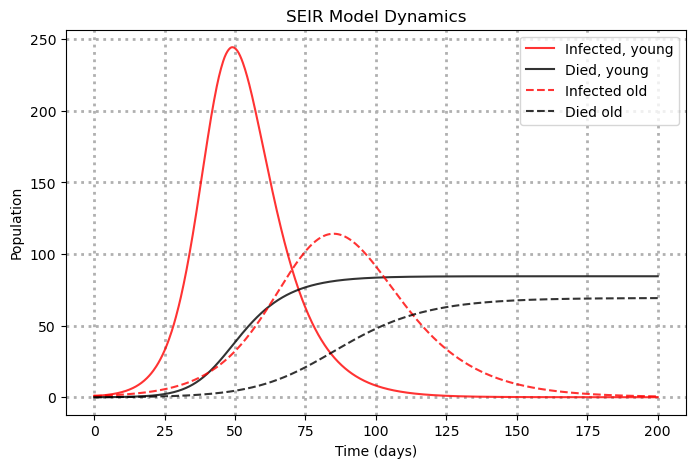

In [9]:
S_plot, E_plot, I_plot, R_plot, D_plot = Y_yt

# plot the data on four separate curves for S(t), E(t), I(t) and R(t)
plt.figure(figsize=(8,5))
#plt.plot(t, S_plot, 'b', label='Susceptible, young', alpha=0.8)
#plt.plot(t, E_plot, 'y', label='Exposed')
plt.plot(t, I_plot, 'r', label='Infected, young', alpha=0.8)
#plt.plot(t, R_plot, 'g', label='Recovered, young', alpha=0.8)
plt.plot(t, D_plot, 'k', label='Died, young', alpha=0.8)
plt.title("SEIR Model Dynamics")
plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.legend()
plt.grid(lw=2,ls=":")

S_plot, E_plot, I_plot, R_plot, D_plot = Y_ot

# plot the data on four separate curves for S(t), E(t), I(t) and R(t)
#plt.figure(figsize=(20,11))
#plt.plot(t, S_plot, 'b--', label='Susceptible old', alpha=0.8)
#plt.plot(t, E_plot, 'y', label='Exposed')
plt.plot(t, I_plot, 'r--', label='Infected old', alpha=0.8)
#plt.plot(t, R_plot, 'g--', label='Recovered old', alpha=0.8)
plt.plot(t, D_plot, 'k--', label='Died old', alpha=0.8)
plt.title("SEIR Model Dynamics")
plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.legend()
plt.grid(lw=2,ls=":")

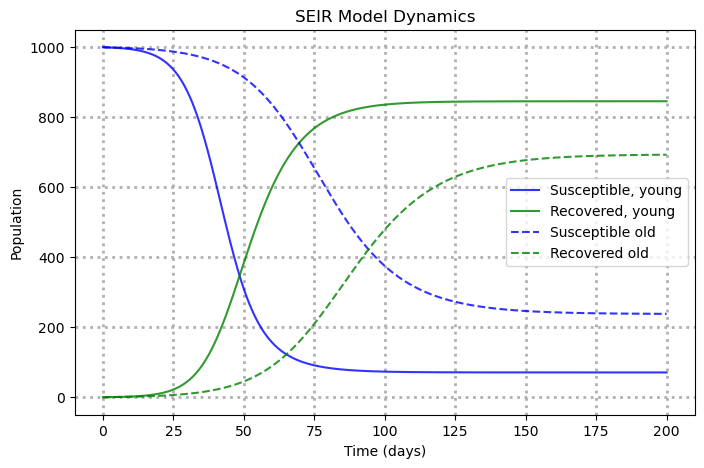

In [10]:
S_plot, E_plot, I_plot, R_plot, D_plot = Y_yt

# plot the data on four separate curves for S(t), E(t), I(t) and R(t)
plt.figure(figsize=(8,5))
plt.plot(t, S_plot, 'b', label='Susceptible, young', alpha=0.8)
#plt.plot(t, E_plot, 'y', label='Exposed')
#plt.plot(t, I_plot, 'r', label='Infected, young', alpha=0.8)
plt.plot(t, R_plot, 'g', label='Recovered, young', alpha=0.8)
#plt.plot(t, D_plot, 'k', label='Died, young', alpha=0.8)
plt.title("SEIR Model Dynamics")
plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.legend()
plt.grid(lw=2,ls=":")

S_plot, E_plot, I_plot, R_plot, D_plot = Y_ot

# plot the data on four separate curves for S(t), E(t), I(t) and R(t)
#plt.figure(figsize=(20,11))
plt.plot(t, S_plot, 'b--', label='Susceptible old', alpha=0.8)
#plt.plot(t, E_plot, 'y', label='Exposed')
#plt.plot(t, I_plot, 'r--', label='Infected old', alpha=0.8)
plt.plot(t, R_plot, 'g--', label='Recovered old', alpha=0.8)
#plt.plot(t, D_plot, 'k--', label='Died old', alpha=0.8)
plt.title("SEIR Model Dynamics")
plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.legend()
plt.grid(lw=2,ls=":")

# SIRD just for ease. 

In [11]:
# the SEIR model differential equations
def deriv(t, Y, N_y, N_o, beta_ybox, beta_obox, gamma, delta, theta_yo, theta_oy):
    Y_y , Y_o = Y.reshape(2,4)
    S_y, I_y, R_y, D_y = Y_y
    S_o, I_o, R_o, D_o = Y_o

    N_ybox = (1.0 - theta_yo)*(S_y + I_y + R_y) + theta_oy * (S_o + I_o + R_o)
    N_obox = (1.0 - theta_oy)*(S_o + I_o + R_o) + theta_yo * (S_y + I_y + R_y)

    I_ybox = (1.0 - theta_yo)*I_y + theta_oy*I_o
    I_obox = (1.0 - theta_oy)*I_o + theta_yo*I_y

    S_y_in_ybox = S_y*(1-theta_yo)
    S_o_in_obox = S_o*(1-theta_oy)
    S_y_in_obox = S_y * theta_yo
    S_o_in_ybox = S_o * theta_oy
    
    dS_ydt = -beta_ybox*S_y_in_ybox*I_ybox / N_ybox  - beta_obox * S_y_in_obox * I_obox / N_obox
    dS_odt = -beta_obox*S_o_in_obox*I_obox / N_obox  - beta_ybox * S_o_in_ybox * I_ybox / N_ybox
    
    dI_ydt = -dS_ydt - (gamma + delta) * I_y
    dI_odt = -dS_odt - (gamma + delta) * I_o
    
    dR_ydt = gamma * I_y
    dR_odt = gamma * I_o
    
    dD_ydt = delta * I_y
    dD_odt = delta * I_o

    dY_ydt = [dS_ydt, dI_ydt, dR_ydt, dD_ydt]
    dY_odt = [dS_odt, dI_odt, dR_odt, dD_odt]

    
    return np.array([dY_ydt, dY_odt]).flatten()

In [36]:
# theotal population we are modeling -  N
N_y , N_o = 1000, 1000
# the initial number of infected and recovered individuals in our data
I_y0, R_y0, I_o0, R_o0 = 1, 0, 0, 0
# the initial number of folk dead from the disease is zero
D_y0, D_o0 = 0, 0
# everyone else, S0, is susceptible to infection initially
S_y0 = N_y - I_y0 - R_y0 - D_y0
S_o0 = N_o - I_o0 - R_o0 - D_o0

# the contact rate, beta, incubation rate, sigma, and mean recovery rate, gamma
beta_ybox, beta_obox = 0.2, 0.1

gamma, delta = 0.1, 0.01

# the coupling rate between the boxes. 
theta_yo , theta_oy = 0.0, 0.1

# the time points (days) over which we want to predict using our model
t = np.linspace(0, 400, 8000)

# here we set the initial conditions vector
Y_y0 = S_y0, I_y0, R_y0, D_y0
Y_o0 = S_o0, I_o0, R_o0, D_o0

Y0 = np.array([Y_y0, Y_o0]).reshape(8)

print("Starting vector = ",Y0)
print("Parameters:\n beta_ybox = {},\n beta_obox = {},\n gamma = {},\n delta = {},\n theta_yo = {},\n theta_oy = {},\n".format(beta_ybox,
                                                                                                                                             beta_obox,
                                                                                                                      gamma,
                                                                                                                      delta,
                                                                                                                      theta_yo,
                                                                                                                      theta_oy))

Starting vector =  [ 999    1    0    0 1000    0    0    0]
Parameters:
 beta_ybox = 0.2,
 beta_obox = 0.1,
 gamma = 0.1,
 delta = 0.01,
 theta_yo = 0.0,
 theta_oy = 0.1,



In [37]:
# Now we use scipy to solve the system of differential equations
sol = solve_ivp(deriv, [0, 400], Y0, args=(N_y, N_o, beta_ybox, beta_obox, gamma, delta, theta_yo, theta_oy), t_eval=t)

sol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  5.001e-02 ...  3.999e+02  4.000e+02]
        y: [[ 9.990e+02  9.990e+02 ...  2.708e+02  2.708e+02]
            [ 1.000e+00  1.004e+00 ...  1.486e-04  1.483e-04]
            ...
            [ 0.000e+00  2.275e-06 ...  3.055e+02  3.055e+02]
            [ 0.000e+00  2.275e-07 ...  3.055e+01  3.055e+01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 140
     njev: 0
      nlu: 0

In [38]:
# extract the results
Y_yt, Y_ot = sol.y.reshape(2,4,len(t))

S_yt, I_yt, R_yt, D_yt = Y_yt
S_ot, I_ot, R_ot, D_ot = Y_ot

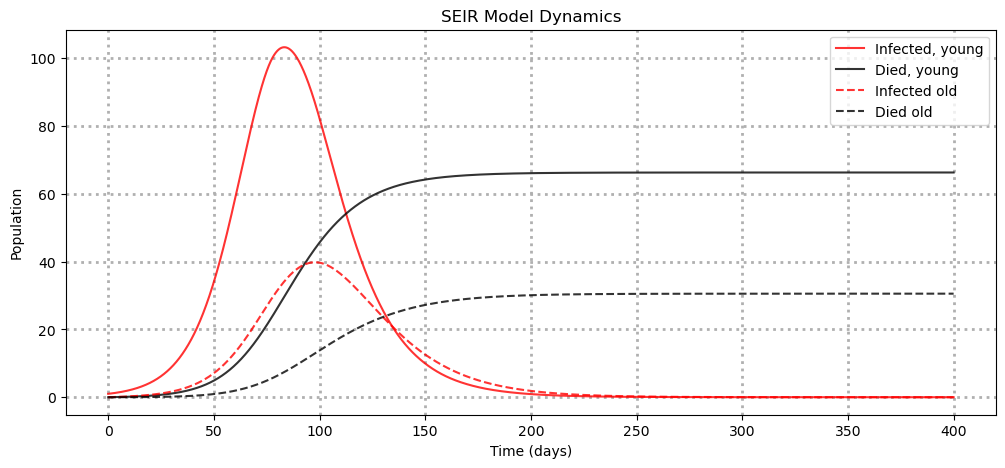

In [39]:
S_plot, I_plot, R_plot, D_plot = Y_yt

# plot the data on four separate curves for S(t), E(t), I(t) and R(t)
plt.figure(figsize=(12,5))
#plt.plot(t, S_plot, 'b', label='Susceptible, young', alpha=0.8)
plt.plot(t, I_plot, 'r', label='Infected, young', alpha=0.8)
#plt.plot(t, R_plot, 'g', label='Recovered, young', alpha=0.8)
plt.plot(t, D_plot, 'k', label='Died, young', alpha=0.8)
plt.title("SEIR Model Dynamics")
plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.legend()
plt.grid(lw=2,ls=":")

S_plot, I_plot, R_plot, D_plot = Y_ot

# plot the data on four separate curves for S(t), E(t), I(t) and R(t)
#plt.figure(figsize=(20,11))
#plt.plot(t, S_plot, 'b--', label='Susceptible old', alpha=0.8)
plt.plot(t, I_plot, 'r--', label='Infected old', alpha=0.8)
#plt.plot(t, R_plot, 'g--', label='Recovered old', alpha=0.8)
plt.plot(t, D_plot, 'k--', label='Died old', alpha=0.8)
plt.title("SEIR Model Dynamics")
plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.legend()
plt.grid(lw=2,ls=":")

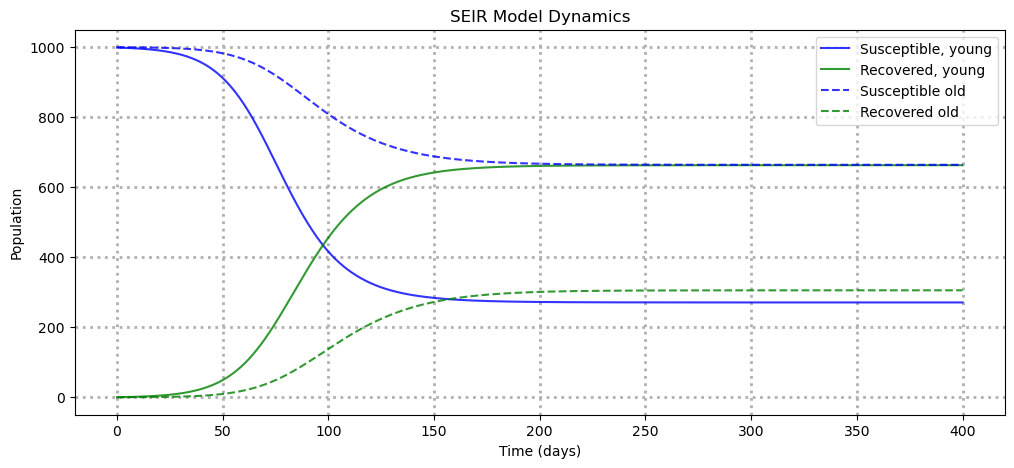

In [40]:
S_plot, I_plot, R_plot, D_plot = Y_yt

# plot the data on four separate curves for S(t), E(t), I(t) and R(t)
plt.figure(figsize=(12,5))
plt.plot(t, S_plot, 'b', label='Susceptible, young', alpha=0.8)
#plt.plot(t, I_plot, 'r', label='Infected, young', alpha=0.8)
plt.plot(t, R_plot, 'g', label='Recovered, young', alpha=0.8)
#plt.plot(t, D_plot, 'k', label='Died, young', alpha=0.8)
plt.title("SEIR Model Dynamics")
plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.legend()
plt.grid(lw=2,ls=":")

S_plot, I_plot, R_plot, D_plot = Y_ot

# plot the data on four separate curves for S(t), E(t), I(t) and R(t)
#plt.figure(figsize=(20,11))
plt.plot(t, S_plot, 'b--', label='Susceptible old', alpha=0.8)
#plt.plot(t, I_plot, 'r--', label='Infected old', alpha=0.8)
plt.plot(t, R_plot, 'g--', label='Recovered old', alpha=0.8)
#plt.plot(t, D_plot, 'k--', label='Died old', alpha=0.8)
plt.title("SEIR Model Dynamics")
plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.legend()
plt.grid(lw=2,ls=":")

## Observations:

1) It seems that the only way of reducing the overall number of deaths in a category is to reduce the infectiousness $\beta$ for that compartment. If that happens, the overall number of dead in the limit of large $t$ is lower (although there is a larger number of susceptible left at the end).

2) If the coupling $\theta$ is very small, then having different infectivities $\beta$ for each environment is relevant. However, the larger $\theta$ is, the less different $\beta$ values matter. As expected, $\theta = 0$ gives completely decoupled populations, and $\theta = 0.5$ gives perfectly mixed populations. $\theta > 0.5$ has an interesting swapover, where the "old" population spend most of their time in a high$\beta$ environment, and thus actually die more.

3) It ultimately works on the idea that the disease dies out before the entire population is infected due to herd immunity. If the whole population gets infected, then the total number of deaths will be the same in the long run.

4) Theta does not need to be symmetric, i.e. the outcome when $\theta_{yo}$ and $\theta_{oy}$ are switched is not the same. Indeed if $\beta$ is not the same for both populations, then $\theta$ being switched changes the curves significantly. 

# Generalized multi-population SIRD Model 

The number of susceptible $S$, infectious $I$, recovered $R$, and deceased (or non-interacting) $D$ for a given population $i$ is stored in the Y matrix: $Y^{i}_{c}$, where $i$ is the population (stored in rows), and $c$ is the category ($S^i$, $I^i$, $R^i$ or $D^i$). Thus, in this case $Y$ is an $N$ by 4 matrix, where $N$ is the number of different populations. 




The $\theta$ matrix contains information about how the populations mix. It is an $N$ by $N$ matrix $\theta^j_i$, each element of which has the proportion of population $j$ that spend that timestep in the environment of population $i$. It can also be thought of as the probability that a person from population $i$ will spend time in the environment of population $j$. $\sum_{j} \theta^j_i = 1$. 

$$ \sum_{i} \theta^j_i ~ Y^{i}_{c} = B^{j}_{c}, $$

where $B^j_c$ is an $N$ by 4 matrix of the number of people in environment $j$ (e.g. young-people env, old folk env) that are of type $c$ (susceptible, infectious, recovered, or dead). 


In [17]:
test_matrix = np.array([[0.9,0.01,0.08,0.01],[1.0,0.0,0.0,0.0]])
test_matrix[:,0] + test_matrix[:,1]

array([0.91, 1.  ])

In [18]:
# the SEIR model differential equations
def deriv_matrix(t, Y, beta_vector, gamma, delta, theta_matrix):
    Y_matrix = Y.reshape(num_populations, 4)

    S, I, R, D = Y_matrix.T
    
    B_env_matrix = np.matmul(theta_matrix, Y_matrix)

    S_env, I_env, R_env, D_env = B_env_matrix.T
    
    N_active_env = S_env + I_env + R_env  # just adds S, I, and R

    # The vulnerable matrix ---- says which

    dYdt = np.zeros(Y_matrix.shape)
    
    new_infections_by_pop = np.zeros(len(S))
    
    for i, s_i in enumerate(S):
        new_infections_by_pop[i] = np.matmul(s_i * theta_matrix.T[i] , beta_vector * I_env / N_active_env)
    
    dYdt = np.array([-new_infections_by_pop, 
                     new_infections_by_pop - I*(gamma+delta), 
                     gamma*I,  
                     delta*I]).T

    return dYdt.flatten()

In [22]:
def simple_error_checks(Y_matrix_0, N_vector, beta_vector, gamma, delta, theta_matrix):
    if not Y_matrix_0.shape == (len(N_vector), 4):
        raise Exception("Y_matrix_0 is not the right shape for N_vector")
    if not len(beta_vector) == Y_matrix_0.shape[0]:
        raise Exception("beta vector is not the same length as Y_matrix_0 (the number of pops)")
    if not theta_matrix.shape == (len(beta_vector), len(beta_vector)):
        raise Exception("theta_matrix is not N by N, where N is the length of the beta_vector and the number of populations")
    if not np.array_equal(theta_matrix.sum(axis=0), np.ones(len(beta_vector))):
        raise Exception("the theta_matrix isn't properly normalized (all columns should add to one)")

In [25]:
Y_matrix_0 = np.array([[999, 1, 0, 0],
                       [1000, 0, 0, 0]])

num_populations = Y_matrix_0.shape[0]

N_vector = Y_matrix_0.sum(axis=1)

# the contact rate, beta, incubation rate, sigma, and mean recovery rate, gamma
beta_vector = np.array([0.2, 0.1])

gamma, delta = 0.1, 0.01

# the coupling matrix between the boxes. 
theta_matrix = np.array([[1.0, 0.1],
                         [0.0, 1-0.1]])

print("Number of populations = {}\n".format(num_populations))
print(" Starting vector = \n",Y_matrix_0)

print("\nParameters:\n beta_vector = ",beta_vector)
print(" gamma = {},\n delta = {},\n".format(gamma, delta))
print(" theta_matrix = \n",theta_matrix)

# Do some simple error checks
simple_error_checks(Y_matrix_0, N_vector, beta_vector, gamma, delta, theta_matrix)

# the time points (days) over which we want to predict using our model
t = np.linspace(0, 400, 8000)

print("\n\nReady to go!")

Number of populations = 2

 Starting vector = 
 [[ 999    1    0    0]
 [1000    0    0    0]]

Parameters:
 beta_vector =  [0.2 0.1]
 gamma = 0.1,
 delta = 0.01,

 theta_matrix = 
 [[1.  0.1]
 [0.  0.9]]


Ready to go!


In [26]:
# Now we use scipy to solve the system of differential equations
solmat = solve_ivp(deriv_matrix, 
                   [0, 400], 
                   Y_matrix_0.flatten(), 
                   args=(beta_vector, gamma, delta, theta_matrix), 
                   t_eval=t)

solmat

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  5.001e-02 ...  3.999e+02  4.000e+02]
        y: [[ 9.990e+02  9.990e+02 ...  2.708e+02  2.708e+02]
            [ 1.000e+00  1.004e+00 ...  1.486e-04  1.483e-04]
            ...
            [ 0.000e+00  2.275e-06 ...  3.055e+02  3.055e+02]
            [ 0.000e+00  2.275e-07 ...  3.055e+01  3.055e+01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 140
     njev: 0
      nlu: 0

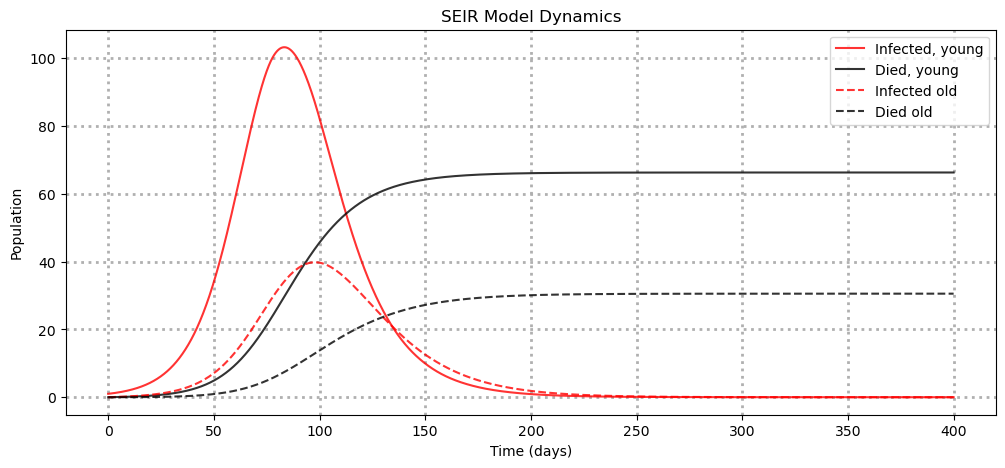

In [29]:
Y_t = solmat.y.reshape(2,4,len(t))

S_plot, I_plot, R_plot, D_plot = Y_t[0]

# plot the data on four separate curves for S(t), E(t), I(t) and R(t)
plt.figure(figsize=(12,5))
#plt.plot(t, S_plot, 'b', label='Susceptible, young', alpha=0.8)
plt.plot(t, I_plot, 'r', label='Infected, young', alpha=0.8)
#plt.plot(t, R_plot, 'g', label='Recovered, young', alpha=0.8)
plt.plot(t, D_plot, 'k', label='Died, young', alpha=0.8)

S_plot, I_plot, R_plot, D_plot = Y_t[1]

# plot the data on four separate curves for S(t), E(t), I(t) and R(t)
#plt.figure(figsize=(20,11))
#plt.plot(t, S_plot, 'b--', label='Susceptible old', alpha=0.8)
plt.plot(t, I_plot, 'r--', label='Infected old', alpha=0.8)
#plt.plot(t, R_plot, 'g--', label='Recovered old', alpha=0.8)
plt.plot(t, D_plot, 'k--', label='Died old', alpha=0.8)
plt.title("SEIR Model Dynamics")
plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.legend()
plt.grid(lw=2,ls=":")

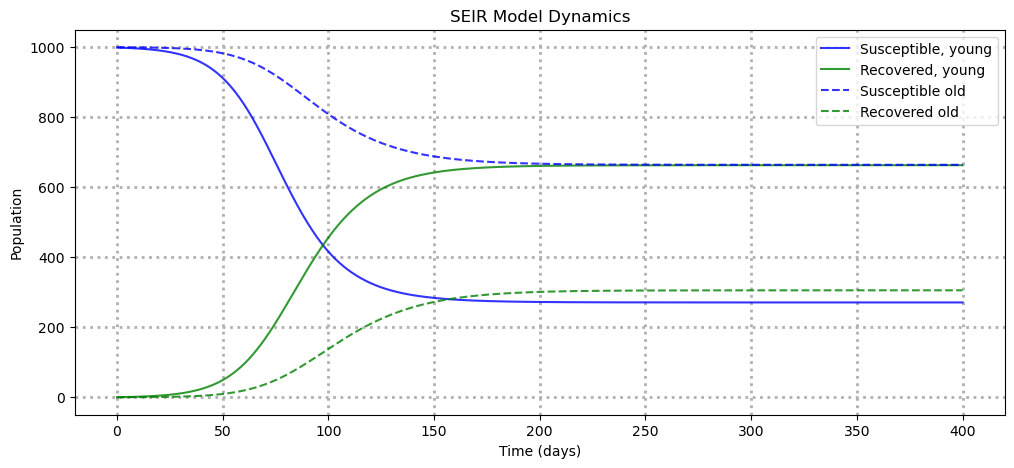

In [30]:
Y_t = solmat.y.reshape(2,4,len(t))

S_plot, I_plot, R_plot, D_plot = Y_t[0]

# plot the data on four separate curves for S(t), E(t), I(t) and R(t)
plt.figure(figsize=(12,5))
plt.plot(t, S_plot, 'b', label='Susceptible, young', alpha=0.8)
#plt.plot(t, I_plot, 'r', label='Infected, young', alpha=0.8)
plt.plot(t, R_plot, 'g', label='Recovered, young', alpha=0.8)
#plt.plot(t, D_plot, 'k', label='Died, young', alpha=0.8)

S_plot, I_plot, R_plot, D_plot = Y_t[1]

# plot the data on four separate curves for S(t), E(t), I(t) and R(t)
#plt.figure(figsize=(20,11))
plt.plot(t, S_plot, 'b--', label='Susceptible old', alpha=0.8)
#plt.plot(t, I_plot, 'r--', label='Infected old', alpha=0.8)
plt.plot(t, R_plot, 'g--', label='Recovered old', alpha=0.8)
#plt.plot(t, D_plot, 'k--', label='Died old', alpha=0.8)
plt.title("SEIR Model Dynamics")
plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.legend()
plt.grid(lw=2,ls=":")

## New Zealand Age Population

We're going to do it with some ages, and the aim to get the $t \rightarrow \infty$ limit for the number of deaths equal to the total number of deaths of the age ranges and sexes.